In [2]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels

# Processing Data from PostGRES Output

In [19]:
fileprefix = "pilot_2" # pilot_[1,2,4]
filepath = '../results/{}_results.json'.format(fileprefix)


In [20]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [21]:
part_data = {}

for participant in all_data['values']:
    part_object = json.loads(participant[17])
    part_object["Beginhit"] = participant[11]
    part_object["Beginexp"] = participant[12]
    part_object["Endhit"] = participant[13]
    part_object["psiturkStatus"] = participant[15]
    part_object["browser"] = participant[5]
    part_object["platform"] = participant[6]
    part_object["language"] = participant[7]
    
    part_data[part_object["workerId"]] = part_object
    with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
        json.dump(part_object, fw)

In [22]:
part_data.keys()


dict_keys(['5eb40f1f0d916d20d9db9144', '60f5a773c448898bf72987bc', '5e8a0912524dca6ad71ecb86', '613cfaecee50fc5d702c9cfc', '60c49e68081928c86ba7b98a', '5acdd627436f5500010046ac', '5c430039e972300001ac04f3', '6169dc7d34d85e70201ee321', '61670b85f91be7f7618712b5', '5d1cc0603690a90017b7fde9', '60f35298d49211f5e58f2ac2', '61212548227146794559af84', '5f8d00ca25aa354b7063d7c7', '5fa7e834819bc858e470ae14', '5db99138bcd46f000ed93841', '60b8b5dcb46db8ae98d0b047', '6130ceb2390f7cb3284f33a9', '615f371e6688c87e53e7acf5', '6140be2fdc5e6f433f412f7a', '60a51393b86b6c9753bb36da', '62cea839eb104e720d1fc9b3', '5df76aff2d2185502504d15c', '5f71e885e4c6b907c3c3610f', '5c5dfb15034e2800016454aa', '6155e6b88ae22eea42c5503c', '615df4407595b67e50cf886b', '5e8233caf510ba08eb222906', '5e0f649eabec5d678a6f11bb', '60365a98a8b60fcb5bf8d9e4', '6151c64a4c0d073be1927c49', '5e42b6421f44d3143440b25c', '5f503987fc18901a2c94c407', '5c3747496d465f00011a4d21', '5c86b96a34daa70017e9341f', '61114c31631413f937fa08cb', '6164e1b2

# Analyzing Trial Data

In [23]:
part = part_data['5eb40f1f0d916d20d9db9144']
part["Beginhit"]

'2022-08-19 17:09:00.819288'

In [24]:
part_stats_dicts = []
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    effort = "-1"
    
    firstTrialStamp = participant['data'][0]['dateTime']
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    finishHITReached = False
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "finishHITReached": finishHITReached
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

fullscreen		0
instructions	exp_instructions_distractor	1
instructions	color_game_instructions	2
html-keyboard-response	stroop_1_ready_1	3
html-keyboard-response	stroop-congruent-22	4
html-keyboard-response	stroop-incongruent-24	5
html-keyboard-response	stroop-incongruent-7	6
html-keyboard-response	stroop-unrelated-24	7
html-keyboard-response	stroop-incongruent-4	8
html-keyboard-response	stroop-congruent-14	9
html-keyboard-response	stroop-incongruent-3	10
html-keyboard-response	stroop-incongruent-19	11
html-keyboard-response	stroop-congruent-3	12
html-keyboard-response	stroop-unrelated-27	13
html-keyboard-response	stroop-congruent-2	14
html-keyboard-response	stroop-unrelated-28	15
html-keyboard-response	stroop-unrelated-17	16
html-keyboard-response	stroop-unrelated-5	17
html-keyboard-response	stroop-unrelated-9	18
html-keyboard-response	stroop-unrelated-22	19
html-keyboard-response	stroop-unrelated-13	20
html-keyboard-response	stroop-congruent-18	21
html-keyboard-response	stroop-congrue

In [25]:
# Calculating the bonus conversion rate for each condition

max_bonus = 2.0

bonus_calc_cols = ["condition", "finalScore"]
bonus_calc_stats_df = pd.DataFrame(part_stats_dicts, columns=bonus_calc_cols)

bonus_rate = {}

for condition in np.unique(bonus_calc_stats_df.condition):
    bonus_rate[condition] = max_bonus / bonus_calc_stats_df.loc[bonus_calc_stats_df.condition == condition].finalScore.max()


# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

# Adding the bonus for each participant
for part in part_stats_dicts:
    part['bonus'] = bonus_rate[part['condition']] * part['finalScore']


In [26]:
df_cols = ["workerId", "Beginhit", "hitLength", "expLength", "stroop1Length", "stroop1Completed", "stroop1Correct", "numQuizAttempts", "numTrialsCompleted", "finalScore", "bonus", "stroop2Completed", "stroop2Correct", "dropoutPoint", "secretCodeReached", "psiturkStatus", "effort"]

stats_df = pd.DataFrame(part_stats_dicts, columns=df_cols)
stats_df

,workerId,Beginhit,hitLength,expLength,stroop1Length,stroop1Completed,stroop1Correct,numQuizAttempts,numTrialsCompleted,finalScore,bonus,stroop2Completed,stroop2Correct,dropoutPoint,secretCodeReached,psiturkStatus,effort
0,5eb40f1f0d916d20d9db9144,2022-08-19 17:09:00.819288,2341.545,2341.545,757.299,450,437,2.0,30,1439.00,2.000000,159,150,s2,NaN,2,-1
1,60f5a773c448898bf72987bc,2022-08-19 16:28:46.198583,1759.000,1735.000,0.000,0,0,1.0,100,1267.75,1.648034,0,0,None,NaN,3,0
2,5e8a0912524dca6ad71ecb86,2022-08-19 16:29:17.222208,3518.669,3518.669,0.000,0,0,1.0,37,592.75,0.770556,0,0,mdp,NaN,2,-1
3,613cfaecee50fc5d702c9cfc,2022-08-19 16:27:58.113497,240.068,240.068,0.000,0,0,1.0,0,0.00,0.000000,0,0,mdp,NaN,6,-1
4,60c49e68081928c86ba7b98a,2022-08-19 16:30:01.016043,2412.000,2149.000,0.000,0,0,2.0,100,1345.25,1.748781,0,0,None,NaN,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,612f3f73f0f8086722abf5c5,2022-08-22 14:56:03.884370,2199.000,2185.000,0.000,0,0,1.0,120,1265.25,1.719382,0,0,None,NaN,3,1
64,60e46e6f6bc0c2cdf5d077ce,2022-08-22 14:55:31.265755,1130.949,1130.949,0.000,0,0,2.0,0,0.00,0.000000,0,0,mdp,NaN,6,-1
65,5f63c23441886d11737a8c4f,2022-08-22 14:56:33.877228,2179.000,2165.000,0.000,0,0,1.0,120,1312.50,1.783591,0,0,None,NaN,3,1
66,614a360a9ff931cef70c2a33,2022-08-22 14:56:15.222433,1370.472,1370.472,0.000,0,0,1.0,47,193.25,0.262613,0,0,mdp,NaN,6,-1


In [18]:
# Printing bonuses

for idx, row in stats_df.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))

60daf06339acagscef1a00932, 0.00
60fcddd9dc7d3ad03fc61f4a, 1.22
607f24e8b07e4d446fc85698, 1.90
5cf92c7255e1370001e54adb, 1.81
56cb8858edf8da000b6df354, 1.44
616962d717541ecf23fbdf9c, 0.00
5f99f15c8171240d32cd450e, 0.27
6077107d2444e8b2290688cf, 0.00
61436594450b2f391b63b5ce, 1.55
60c9c12dd3f1aba0a0ff9949, 1.83
60194185dc1e1f00083cb6c6, 1.73
60fc39cce64c39328a7c8904, 2.00


In [31]:
df_cols = ["workerId", "condition", "numQuizAttempts", "numTrialsCompleted", "propWithheld", "finalScore", "bonus","averageTrialLength", "mouselabLength", "dropoutPoint", "secretCodeReached", "psiturkStatus", "browser", "platform", "language", "effort"]

stats_df = pd.DataFrame(part_stats_dicts, columns=df_cols)
stats_df.loc[stats_df.condition == 0]

,workerId,condition,numQuizAttempts,numTrialsCompleted,propWithheld,finalScore,bonus,averageTrialLength,mouselabLength,dropoutPoint,secretCodeReached,psiturkStatus,browser,platform,language,effort
0,5eb40f1f0d916d20d9db9144,0,2.0,30,0.0,1439.0,2.000000,12073.333333,1000.231,s2,NaN,2,chrome,windows,es-ES,-1
6,5c430039e972300001ac04f3,0,1.0,30,0.0,1088.0,1.512161,17229.266667,716.154,None,NaN,3,firefox,macos,pl,0
7,6169dc7d34d85e70201ee321,0,1.0,30,0.0,1190.0,1.653926,24655.833333,1089.459,None,NaN,3,chrome,windows,en-US,0
8,61670b85f91be7f7618712b5,0,0.0,0,NaN,0.0,0.000000,NaN,0.000,s1,NaN,2,chrome,windows,en-US,-1
9,5d1cc0603690a90017b7fde9,0,1.0,30,0.0,1367.0,1.899931,10578.233333,387.307,None,NaN,3,chrome,windows,pl-PL,0
14,5db99138bcd46f000ed93841,0,2.0,30,0.0,1170.0,1.626129,13723.100000,864.681,None,NaN,3,chrome,windows,it-IT,0
15,60b8b5dcb46db8ae98d0b047,0,4.0,30,0.0,1061.0,1.474635,10791.900000,1304.215,None,NaN,3,chrome,windows,pt-PT,0
16,6130ceb2390f7cb3284f33a9,0,1.0,30,0.0,938.0,1.303683,15535.200000,732.688,s2,NaN,2,chrome,windows,en-GB,-1
17,615f371e6688c87e53e7acf5,0,3.0,30,0.0,1212.0,1.684503,22162.633333,1385.640,None,NaN,3,chrome,windows,en-US,1
18,6140be2fdc5e6f433f412f7a,0,1.0,30,0.0,1240.0,1.723419,15516.866667,900.567,None,NaN,3,chrome,windows,en-US,0


In [10]:
# Analyzing dropouts

relevant_cols = ["workerId", "condition", "hitLength", "stroop1Length", "stroop1Completed", "numQuizAttempts", "numTrialsCompleted", "propWithheld", "finalScore", "bonus","averageTrialLength", "mouselabLength", "stroop2Length", "stroop2Completed", "dropoutPoint", "psiturkStatus", "effort"]
platform_cols = ["workerId", "condition","Beginhit", "browser", "platform", "language","dropoutPoint"]

platform_df = pd.DataFrame(part_stats_dicts, columns=platform_cols)
platform_df.loc[platform_df.condition == 0]

,workerId,condition,Beginhit,browser,platform,language,dropoutPoint
0,5eb40f1f0d916d20d9db9144,0,2022-08-19 17:09:00.819288,chrome,windows,es-ES,s2
6,5c430039e972300001ac04f3,0,2022-08-19 16:28:40.541747,firefox,macos,pl,None
7,6169dc7d34d85e70201ee321,0,2022-08-19 16:33:14.477679,chrome,windows,en-US,None
8,61670b85f91be7f7618712b5,0,2022-08-19 16:52:05.365106,chrome,windows,en-US,s1
9,5d1cc0603690a90017b7fde9,0,2022-08-19 17:05:44.304353,chrome,windows,pl-PL,None
14,5db99138bcd46f000ed93841,0,2022-08-19 16:30:39.651162,chrome,windows,it-IT,None
15,60b8b5dcb46db8ae98d0b047,0,2022-08-19 17:03:47.092529,chrome,windows,pt-PT,None
16,6130ceb2390f7cb3284f33a9,0,2022-08-19 16:30:49.764071,chrome,windows,en-GB,s2
17,615f371e6688c87e53e7acf5,0,2022-08-19 16:55:24.676090,chrome,windows,en-US,None
18,6140be2fdc5e6f433f412f7a,0,2022-08-19 16:30:16.767967,chrome,windows,en-US,None


In [10]:
# Condition 2

cond_2_filtered = stats_df.loc[stats_df.condition==2]
relevant_cols = ["workerId", "hitLength", "expLength", "expLengthSum", "totalLengthSum", "expLengthDiff", "numQuizAttempts", "numTrialsCompleted", "propWithheld", "finalScore", "bonus","averageTrialLength", "mouselabLength", "dropoutPoint", "effort"]
cond_2_filtered = cond_2_filtered[relevant_cols].loc[cond_2_filtered.numTrialsCompleted > 0]
cond_2_filtered

,workerId,hitLength,expLength,expLengthSum,totalLengthSum,expLengthDiff,numQuizAttempts,numTrialsCompleted,propWithheld,finalScore,bonus,averageTrialLength,mouselabLength,dropoutPoint,effort
44,612288702a5316519e4e9602,3044.000,3035.000,2705.362,3034.269,-329.638,1.0,120,0.750000,1261.25,1.713946,18104.666667,2705.362,None,0
45,5e1aed4331d8d93320bc6d4e,3619.000,3614.000,1653.194,3609.015,-1960.806,1.0,120,0.750000,1382.50,1.878716,12394.975000,1653.194,None,1
46,6137dafbe514b520301ed443,2113.000,2104.000,1813.157,2103.441,-290.843,1.0,120,0.750000,1471.75,2.000000,12270.300000,1813.157,None,1
47,614775c6f329a9e5ab190e04,2110.000,2033.000,1760.290,2033.640,-272.710,2.0,120,0.750000,832.25,1.130967,11488.458333,1760.290,None,1
48,616f469494656434f5b4ebc6,4851.000,4739.000,3699.465,4738.730,-1039.535,3.0,120,0.750000,1165.75,1.584169,19891.341667,3699.465,None,0
49,5f5a69a0b2b7c2119ecf07bf,2428.000,2420.000,2064.476,2419.892,-355.524,2.0,120,0.750000,1335.75,1.815186,11761.966667,2064.476,None,0
51,60315645c8c7420a2f1ade9c,4867.000,4836.000,4138.013,4833.866,-697.987,1.0,120,0.750000,872.50,1.185663,28034.441667,4138.013,None,0
52,5ec6583644972a0315eb4f0d,2565.000,2554.000,2236.166,2554.326,-317.834,2.0,120,0.750000,1396.00,1.897061,12309.108333,2236.166,None,0
53,6141210c31f06c30f5f58104,2857.000,2841.000,2388.503,2839.268,-452.497,2.0,120,0.750000,647.50,0.879905,14658.358333,2388.503,None,0
54,5f58d87950e39f07ad1ba367,2745.883,2745.883,2470.680,2745.883,-275.203,4.0,93,0.731183,1077.25,1.463904,15465.978495,2470.680,mdp,-1


In [11]:
# Condition 2 average times:

print("\nExperiment Length (from timestamps):")
print(cond_2_filtered.totalLengthSum.mean() / 60)
print(cond_2_filtered.totalLengthSum.std() / 60)

print("\nExperiment Length (from PsiTurk):")
print(cond_2_filtered.expLength.mean() / 60)
print(cond_2_filtered.expLength.std() / 60)

print("\nMouselab Length")
print(cond_2_filtered.expLengthSum.mean() / 60)
print(cond_2_filtered.expLengthSum.std() / 60)


Experiment Length (from timestamps):
47.087942857142856
15.007061149788393

Experiment Length (from PsiTurk):
47.13219920634921
15.016911508108002

Mouselab Length
39.4709873015873
13.104396161425399


In [11]:
# Condition 0

stats_df_filtered = stats_df.loc[stats_df.condition == 0].loc[stats_df.numTrialsCompleted > 0]

no_dropouts = stats_df_filtered.loc[stats_df_filtered.dropoutPoint.isnull()]

dropouts = stats_df_filtered.loc[stats_df_filtered.dropoutPoint.notnull()]

In [12]:
dropouts

,workerId,condition,hitLength,expLength,expLengthSum,expLengthDiff,totalLengthSum,stroop1Length,stroop1Completed,stroop1Correct,...,mouselabLength,stroop2Length,stroop2Completed,stroop2Correct,dropoutPoint,psiturkStatus,browser,platform,language,effort
0,5eb40f1f0d916d20d9db9144,0,2341.545,2341.545,1998.186,-343.359,2341.545,757.299,450,437,...,1000.231,240.656,159,150,s2,2,chrome,windows,es-ES,-1
16,6130ceb2390f7cb3284f33a9,0,2156.434,2156.434,1858.493,-297.941,2156.434,675.466,450,439,...,732.688,450.339,322,306,s2,2,chrome,windows,en-GB,-1
25,615df4407595b67e50cf886b,0,2415.113,2415.113,2136.598,-278.515,2415.113,794.439,450,441,...,985.318,356.841,221,220,s2,2,chrome,windows,en-ZA,-1
33,5c86b96a34daa70017e9341f,0,2243.474,2243.474,1970.626,-272.848,2243.474,622.037,450,441,...,855.609,492.980,437,431,s2,2,firefox,windows,en-US,-1
38,6133e1b6a8093fd7526e0eda,0,1486.514,1486.514,1323.191,-163.323,1486.514,645.521,450,443,...,466.223,211.447,187,185,s2,2,chrome,windows,fr-FR,-1
39,615e83303bf461137c0fc627,0,2803.456,2803.456,2538.054,-265.402,2803.456,918.989,450,438,...,1365.698,253.367,180,165,s2,6,chrome,windows,es-US,-1


In [14]:
print("\nCondition 0, No Dropouts: {}".format(len(no_dropouts)))
print("\nHIT:")
print(no_dropouts.hitLength.mean() / 60)
print(no_dropouts.hitLength.std() / 60)
print("\nExperiment (from PsiTurk):")
print(no_dropouts.totalLengthSum.mean() / 60)
print(no_dropouts.totalLengthSum.std() / 60)
print("\nExperiment (from timestamps):")
print(no_dropouts.totalLengthSum.mean() / 60)
print(no_dropouts.totalLengthSum.std() / 60)
print("\nExperiment (from individual sums):")
print(no_dropouts.expLengthSum.mean() / 60)
print(no_dropouts.expLengthSum.std() / 60)
print('\nStroop 1:')
print(no_dropouts.stroop1Length.mean() / 60)
print(no_dropouts.stroop1Length.std() / 60)
print('\nMDP:')
print(no_dropouts.mouselabLength.mean() / 60)
print(no_dropouts.mouselabLength.std() / 60)
print('\nStroop 2:')
print(no_dropouts.stroop2Length.mean() / 60)
print(no_dropouts.stroop2Length.std() / 60)

print("\nCondition 0, Dropouts: {}".format(len(dropouts)))
print("\nHIT:")
print(dropouts.hitLength.mean() / 60)
print(dropouts.hitLength.std() / 60)
print("\nExperiment Sum:")
print(dropouts.expLengthSum.mean() / 60)
print(dropouts.expLengthSum.std() / 60)
print("\nExperiment:")
print(dropouts.expLength.mean() / 60)
print(dropouts.expLength.std() / 60)
print('\nStroop 1:')
print(dropouts.stroop1Length.mean() / 60)
print(dropouts.stroop1Length.std() / 60)
print('\nMDP:')
print(dropouts.mouselabLength.mean() / 60)
print(dropouts.mouselabLength.std() / 60)
print('\nStroop 2:')
print(dropouts.stroop2Length.mean() / 60)
print(dropouts.stroop2Length.std() / 60)
print('\nStroop 2 Completed:')
print(dropouts.stroop2Completed.mean())
print(dropouts.stroop2Completed.std())

print("\nCondition 0, All: {}".format(len(stats_df_filtered)))


Condition 0, No Dropouts: 16

HIT:
48.0125
14.327872990937783

Experiment (from PsiTurk):
47.461908333333334
14.144999653040594

Experiment (from timestamps):
47.461908333333334
14.144999653040594

Experiment (from individual sums):
39.03831770833334
9.243863192060768

Stroop 1:
12.793671875
3.751139054512093

MDP:
13.270736458333333
4.51988727298066

Stroop 2:
12.973909375000002
5.174664201107262

Condition 0, Dropouts: 6

HIT:
37.35148888888889
7.200262306469325

Experiment Sum:
32.847633333333334
6.591351065086902

Experiment:
37.35148888888889
7.200262306469325

Stroop 1:
12.260419444444445
1.85878208645747

MDP:
15.016019444444444
5.012877032618834

Stroop 2:
5.571194444444444
1.9658853337665751

Stroop 2 Completed:
251.0
107.83134980143761

Condition 0, All: 22


In [15]:
# Condition 1

stats_df_filtered_2 = stats_df.loc[stats_df.condition == 1].loc[stats_df.numTrialsCompleted > 0]

no_dropouts_2 = stats_df_filtered_2.loc[stats_df_filtered_2.dropoutPoint.isnull()]

dropouts_2 = stats_df_filtered_2.loc[stats_df_filtered_2.dropoutPoint.notnull()]

In [16]:
dropouts_2

,workerId,condition,hitLength,expLength,expLengthSum,expLengthDiff,totalLengthSum,stroop1Length,stroop1Completed,stroop1Correct,...,propWithheld,finalScore,bonus,averageTrialLength,mouselabLength,stroop2Length,stroop2Completed,stroop2Correct,dropoutPoint,effort
2,5e8a0912524dca6ad71ecb86,1,3518.669,3518.669,1289.396,-2229.273,3518.669,0.0,0,0,...,0.675676,592.75,0.770556,24278.756757,1289.396,0.0,0,0,mdp,-1


In [17]:

print("\nCondition 1, No Dropouts: {}".format(len(no_dropouts)))
print("\nHIT:")
print(no_dropouts_2.hitLength.mean() / 60)
print(no_dropouts_2.hitLength.std() / 60)
print("\nExperiment (from timestamps):")
print(no_dropouts_2.totalLengthSum.mean() / 60)
print(no_dropouts_2.totalLengthSum.std() / 60)
print("\nExperiment (from individual sums):")
print(no_dropouts_2.expLengthSum.mean() / 60)
print(no_dropouts_2.expLengthSum.std() / 60)
print('\nStroop 1:')
print(no_dropouts_2.stroop1Length.mean() / 60)
print(no_dropouts_2.stroop1Length.std() / 60)
print('\nMDP:')
print(no_dropouts_2.mouselabLength.mean() / 60)
print(no_dropouts_2.mouselabLength.std() / 60)
print('\nStroop 2:')
print(no_dropouts_2.stroop2Length.mean() / 60)
print(no_dropouts_2.stroop2Length.std() / 60)

print("\nCondition 1, Dropouts:: {}".format(len(dropouts)))
print("\nHIT:")
print(dropouts_2.hitLength.mean() / 60)
print(dropouts_2.hitLength.std() / 60)
print("\nExperiment:")
print(dropouts_2.expLengthSum.mean() / 60)
print(dropouts_2.expLengthSum.std() / 60)
print('\nStroop 1:')
print(dropouts_2.stroop1Length.mean() / 60)
print(dropouts_2.stroop1Length.std() / 60)
print('\nMDP:')
print(dropouts_2.mouselabLength.mean() / 60)
print(dropouts_2.mouselabLength.std() / 60)
print('\nStroop 2:')
print(dropouts_2.stroop2Length.mean() / 60)
print(dropouts_2.stroop2Length.std() / 60)


Condition 1, No Dropouts: 16

HIT:
41.21584444444444
15.995064535844177

Experiment (from timestamps):
40.355688888888885
14.835255766043108

Experiment (from individual sums):
35.507555555555555
13.51193961938123

Stroop 1:
0.0
0.0

MDP:
35.507555555555555
13.51193961938123

Stroop 2:
0.0
0.0

Condition 1, Dropouts:: 6

HIT:
58.64448333333333
nan

Experiment:
21.489933333333333
nan

Stroop 1:
0.0
nan

MDP:
21.489933333333333
nan

Stroop 2:
0.0
nan


In [16]:
# Average stats

stats_df_filtered = stats_df.loc[stats_df.dropoutPoint.isnull()]

all_trials = [part['trialLengths'] for part in part_stats_dicts]
all_trials_scores = [part['trialScores'] for part in part_stats_dicts]
all_trials_flat = np.array([item for sublist in all_trials for item in sublist])

print("Number of participants: {}".format(len(stats_df_filtered)))

print("\nAverage Experiment Length (mins) (mean/sd)")
print(stats_df_filtered['expLength'].mean()/60)
print(stats_df_filtered['expLength'].std()/60)

print("\nAverage Trial Length (secs) (mean/sd)")
print(all_trials_flat.mean()/1000)
print(all_trials_flat.std()/1000)

print("\nAverage experiment score (mean/sd)")
print(stats_df_filtered['finalScore'].mean())
print(stats_df_filtered['finalScore'].std())

print("\nAverage bonus (mean/sd)")
print(stats_df_filtered['bonus'].mean())
print(stats_df_filtered['bonus'].std())

Number of participants: 9

Average Experiment Length (mins) (mean/sd)
49.30185185185186
22.644838516089116

Average Trial Length (secs) (mean/sd)
14.125151851851852
15.319290872618875

Average experiment score (mean/sd)
1029.7777777777778
358.1224573305121

Average bonus (mean/sd)
1.5278602044180678
0.5313389574636679


In [19]:
all_trials_done = np.array([l for l in all_trials_scores if len(l) > 0])

plt.errorbar(range(all_trials_done.shape[1]), all_trials_done.mean(axis=0), yerr=all_trials_done.std(axis=0))


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_20692/3770553002.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_trials_done = np.array([l for l in all_trials_scores if len(l) > 0])


IndexError: tuple index out of range

In [ ]:
# Bonuses
print("All: ")
for idx, row in stats_df.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], float(row['bonus'])))


In [ ]:
# Bonuses
print("All: ")
for idx, row in cond_2_filtered.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], (float(row['bonus']))))

In [20]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: no
Comments: no


Feedback: No
Comments: None


Feedback: No


Feedback: Not at all. It was all fun.
Comments: It was fun, thank you. Only if I was getting all that money...Just kidding. Thanks for the great game.


Feedback: with the practice, all to be clarified


Feedback: Not really 


Feedback: No, at all. The instructions were fully understandable.


Feedback: no


Feedback: no.


Feedback: when a color name appeared with a different text color, it was difficult to process...
Comments: None 


Feedback: no


Feedback: no
Comments: no


Feedback: Not at all.
Comments: No.


Feedback: everything was simple and easy to understand
Comments: i think that fullscreen mode made it harder to focus on colore game 


Feedback: No, everything was clear


Feedback: No. Everything was very well explained. 
Comments: It was fun! Good luck with your research and thank you for the opportunity! 


Feedback: No
Comments: None


Feedback: No


Feedback: No.
Comments: No.


Feedback: No


F

In [21]:
# Compiling scores of rewarded trials in both conditions

scarce_rewarded_scores = []
scarce_scores_all = []
non_scarce_rewarded_scores = []

for part in part_stats_dicts:
    if part['condition'] == 0:
        # Skip dropouts
        if len(part['trialScores']) == 30:    
            non_scarce_rewarded_scores.append(part['trialScores'])
    elif part['condition'] == 2:
        # Skip dropouts
        if len(part['trialScores']) == 120:
            scarce_scores_all.append(part['trialScores'])
            scarce_rewarded_scores.append([score for (score, withheld) in zip(part['trialScores'], part['rewardsWithheld']) if not withheld])

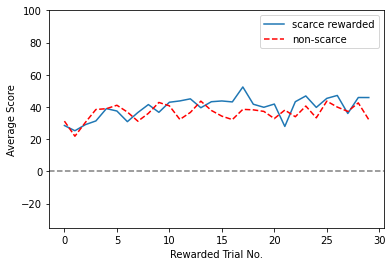

In [32]:
scarce = np.array(scarce_rewarded_scores)
non_scarce = np.array(non_scarce_rewarded_scores)
scarce_first_30 = np.array([scores[0:30] for scores in scarce_scores_all])

#plt.errorbar(range(scarce.shape[1]), scarce.mean(axis=0), yerr=scarce.std(axis=0), label='scarce rewarded')
#plt.errorbar(range(scarce_first_30.shape[1]), scarce_first_30.mean(axis=0), yerr=scarce_first_30.std(axis=0), label='scarce first 30')
#plt.errorbar(range(non_scarce.shape[1]), non_scarce.mean(axis=0), yerr=non_scarce.std(axis=0), color='r', linestyle='--', label='non-scarce')
plt.plot(range(scarce.shape[1]), scarce.mean(axis=0), label='scarce rewarded')
#plt.plot(range(scarce_first_30.shape[1]), scarce_first_30.mean(axis=0), label='scarce first 30')
plt.plot(range(non_scarce.shape[1]), non_scarce.mean(axis=0), color='r', linestyle='--', label='non-scarce')


plt.legend()
plt.axhline(0, linestyle = '--', color='k', alpha = 0.5)
plt.ylim([-35,100])
plt.xlabel("Rewarded Trial No.")
plt.ylabel("Average Score")
plt.show()

In [23]:
# CSV

import csv
import sys
import json

csv.field_size_limit(sys.maxsize)

part_dicts = []

with open('../results/pilot_2.0_results.csv', newline='') as f:
    csv_file = csv.reader(f)
    for idx, row in enumerate(csv_file):
        if idx != 0:
            part_dicts.append(json.loads(row[-1]))

for part in part_dicts:
    if part['workerId'].startswith("5eb40f1f0d916d20d9db9144"):
        print(len(part['data']))
        print(part['data'][-1])

666
{'uniqueid': '5eb40f1f0d916d20d9db9144:62ffb73fe31bae241538cb8a', 'current_trial': 665, 'dateTime': 1660931339681, 'trialdata': {'rt': 748, 'stimulus': "<p id='stroop-text' class='stroop-yellow'>YELLOW</p>", 'response': 'y', 'stimulus-type': 'congruent', 'word': 'yellow', 'color': 'yellow', 'correct_response': 'y', 'trial_id': 'stroop-congruent-19', 'trial_type': 'html-keyboard-response', 'trial_index': 665, 'time_elapsed': 2394224, 'internal_node_id': '0.0-16.0-8.0-68.0'}}
